In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec

## Import data

In [15]:
file_confirmed='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
file_deaths='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
file_recovered='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

df_confirmed=pd.read_csv(file_confirmed)
df_deaths=pd.read_csv(file_deaths)
df_recovered=pd.read_csv(file_recovered)

### Data manipulation and representation (World)

In [16]:
deaths_world=df_deaths.iloc[:,-1].sum()
recovered_world=df_recovered.iloc[:,-1].sum()
total_world=df_confirmed.iloc[:,-1].sum()

max_death_rate=round(deaths_world/(deaths_world+recovered_world)*100,1)
min_death_rate=round(deaths_world/total_world*100,1)

print('Total contaminated:',total_world)
print('Total deaths:',deaths_world)
print('Total recovered:',recovered_world)

print('Based on the WHO data, the death rate is between',min_death_rate,'% and',max_death_rate,'% of the confirmed case')

Total contaminated: 119303
Total deaths: 4290
Total recovered: 64411
Based on the WHO data, the death rate is between 3.6 % and 6.2 % of the confirmed case


2.281866343269292
1.3959981386691485


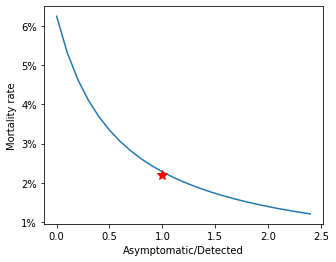

In [17]:
def mortality_rate(f_asympt):
    recovered_tot=recovered_world+f_asympt*total_world
    return deaths_world/(deaths_world+recovered_tot)

print(mortality_rate(1)*100)
print(mortality_rate(2)*100)

f_asympt_grid=np.arange(0,2.5,0.1)

plt.figure(figsize=(5,4))
plt.plot(f_asympt_grid,mortality_rate(f_asympt_grid)*100)
plt.xlabel('Asymptomatic/Detected')
plt.ylabel('Mortality rate')
plt.yticks([1,2,3,4,5,6],['1%','2%','3%','4%','5%','6%'])
plt.plot(1,2.2,marker='*',color='red',markersize=11)
plt.savefig('mortality_rate_plot.png',dpi=300)
plt.show()

In [18]:
def func_plot(df):
    y_world=[]
    n_cols=df.shape[1]
    #print(n_cols)
    for i in range(n_cols-4):
        y_world.append(df.iloc[:,i+4].sum())
    
    x_world2=df.columns[4:]
    x_world=pd.to_datetime(x_world2,format='%m/%d/%y')
    
    return (x_world,y_world)

peppe=func_plot(df_confirmed)

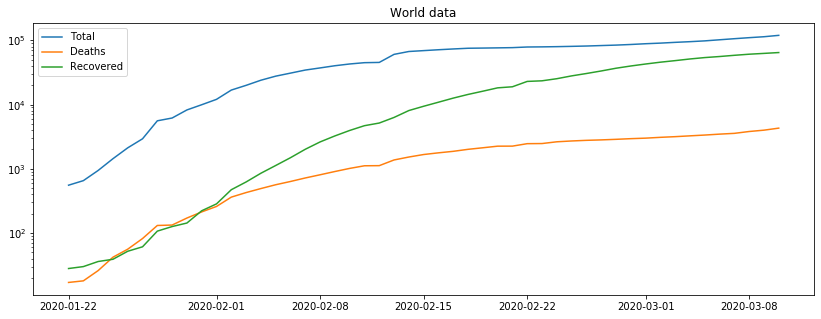

In [19]:
plt.figure(figsize=(14,5))
plt.plot(func_plot(df_confirmed)[0],func_plot(df_confirmed)[1],label='Total')
plt.plot(func_plot(df_deaths)[0],func_plot(df_deaths)[1],label='Deaths')
plt.plot(func_plot(df_recovered)[0],func_plot(df_recovered)[1],label='Recovered')
plt.legend()
plt.yscale('log')
plt.title('World data')
plt.savefig('world_plot.png',dpi=300)
plt.show()

### Data manipulation and representation (single country)

In [20]:
######## INPUT PARAMETERS ########
country='Italy'
t0=pd.to_datetime('2020-02-21')
#################################

mask_ita=df_confirmed['Country/Region']==country   # you can change the country here

df_confirmed_ITA=df_confirmed.loc[mask_ita,:]
df_deaths_ITA=df_deaths.loc[mask_ita,:]
df_recovered_ITA=df_recovered.loc[mask_ita,:]

deaths_world_ITA=df_deaths_ITA.iloc[:,-1].sum()
recovered_world_ITA=df_recovered_ITA.iloc[:,-1].sum()
total_world_ITA=df_confirmed_ITA.iloc[:,-1].sum()

max_death_rate_ITA=round(deaths_world_ITA/(deaths_world_ITA+recovered_world_ITA)*100,1)
min_death_rate_ITA=round(deaths_world_ITA/total_world_ITA*100,1)

print('Total contaminated:',country,total_world_ITA)
print('Total deaths',country,deaths_world_ITA)
print('Total recovered ',country,recovered_world_ITA)

print('Based on the WHO data, the death rate in',country,'is between',min_death_rate_ITA,'% and',max_death_rate_ITA,'% of the total confirmed case')

Total contaminated: Italy 10149
Total deaths Italy 631
Total recovered  Italy 724
Based on the WHO data, the death rate in Italy is between 6.2 % and 46.6 % of the total confirmed case


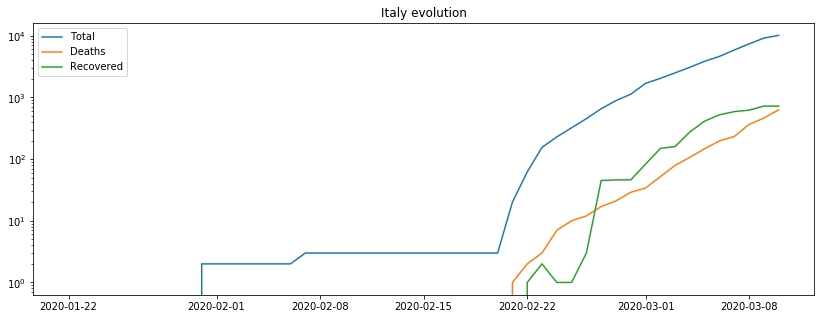

In [21]:
plt.figure(figsize=(14,5))
plt.plot(func_plot(df_confirmed_ITA)[0],func_plot(df_confirmed_ITA)[1],label='Total')
plt.plot(func_plot(df_deaths_ITA)[0],func_plot(df_deaths_ITA)[1],label='Deaths')
plt.plot(func_plot(df_recovered_ITA)[0],func_plot(df_recovered_ITA)[1],label='Recovered')
plt.legend()
plt.yscale('log')
plt.title(country+' evolution')
plt.savefig('country_plot.png',dpi=300)
plt.show()

### Statistical analysis of the single country situation

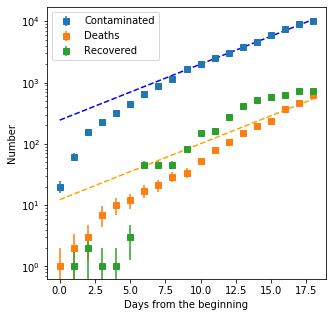

In [22]:
from scipy.optimize import curve_fit

def func(t,t0,a):
    #return (a-b*t)**(t-t0)
    return a**(t-t0)

x_ITA=pd.to_datetime(df_confirmed.columns[4:],format='%m/%d/%y')

tdelta=x_ITA-t0  #this should be adapted to the country

xdata2=tdelta.days
xdata=xdata2[xdata2>=0]

ydata=np.array(func_plot(df_confirmed_ITA)[1])
ydata=ydata[xdata2>=0]

ydata_death=np.array(func_plot(df_deaths_ITA)[1])
ydata_death=ydata_death[xdata2>=0]

ydata_rec=np.array(func_plot(df_recovered_ITA)[1])
ydata_rec=ydata_rec[xdata2>=0]

popt, pcov = curve_fit(func, xdata, ydata,p0=[0,2])

def func_death(t,mort_rate):
    return mort_rate*popt[1]**(t-popt[0])

popt_death, pcov_death = curve_fit(func_death, xdata, ydata_death)

plt.figure(figsize=(5,5))
plt.plot(xdata, func(xdata, *popt), 'b--')
plt.plot(xdata, func_death(xdata, *popt_death), color='orange',linestyle='--')
plt.errorbar(xdata,ydata,np.sqrt(ydata),linestyle='None',label='Contaminated',marker='s')
plt.errorbar(xdata,ydata_death,np.sqrt(ydata_death),linestyle='None',label='Deaths',marker='s')
plt.errorbar(xdata,ydata_rec,np.sqrt(ydata_rec),linestyle='None',label='Recovered',marker='s')
plt.yscale('log')
plt.legend()
plt.xlabel('Days from the beginning')
plt.ylabel('Number')
plt.savefig('evoita.png',dpi=300)
plt.show()

In [23]:
print('The number of contaminated people increases everyday of a factor',round(popt[1],2))

print('Prediction for the number of contaminated people in 1 week',int(func(xdata[-1]+7, *popt)))

print('Prediction for the number of func_deaths in 1 week',int(func_death(xdata[-1]+7, *popt_death)))

The number of contaminated people increases everyday of a factor 1.23
Prediction for the number of contaminated people in 1 week 46913
Prediction for the number of func_deaths in 1 week 2364


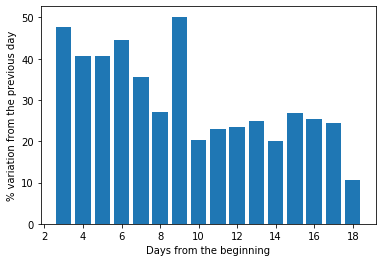

In [24]:
# percentage variation of the contaminted people, compared to the previous day

incremento=[]

for i in range(3,len(ydata)):
    incremento.append((ydata[i]/ydata[i-1]-1)*100)
    
plt.bar(xdata[xdata>=3],incremento)
plt.xlabel('Days from the beginning')
plt.ylabel('% variation from the previous day')
plt.savefig('incr_perc.png',dpi=300)
plt.show()

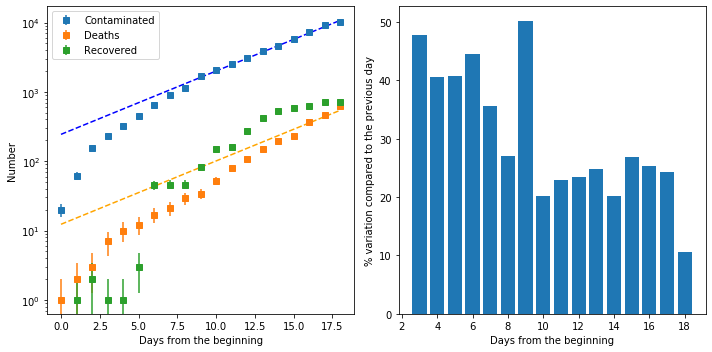

In [25]:
### combined plot

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(xdata, func(xdata, *popt), 'b--')
plt.plot(xdata, func_death(xdata, *popt_death), color='orange',linestyle='--')
plt.errorbar(xdata,ydata,np.sqrt(ydata),linestyle='None',label='Contaminated',marker='s')
plt.errorbar(xdata,ydata_death,np.sqrt(ydata_death),linestyle='None',label='Deaths',marker='s')
plt.errorbar(xdata,ydata_rec,np.sqrt(ydata_rec),linestyle='None',label='Recovered',marker='s')
plt.yscale('log')
plt.legend()
plt.xlabel('Days from the beginning')
plt.ylabel('Number')
plt.subplot(1,2,2)
plt.bar(xdata[xdata>=3],incremento)
plt.xlabel('Days from the beginning')
plt.ylabel('% variation compared to the previous day')
plt.tight_layout()
plt.savefig('combined.png',dpi=300)
plt.show()

In [26]:
# save data from Italy on an external file

vec_ITA=xdata,ydata,ydata_death,ydata_rec
vec_ITA=np.transpose(vec_ITA)

df_ITA=pd.DataFrame(vec_ITA)
df_ITA.columns=(['Time','Infected','Deaths','Recovered'])

if country=='Italy':
    df_ITA.to_csv('dataITA.txt',index=None)
elif country=='Germany':
    df_ITA.to_csv('dataDEU.txt',index=None)